# Direct Marketing Optimization - Code Overview
## Read ME
## Code Workflow
1. **Load and Merge Data**
   - Load demographic, product, transaction, and sales data.
   - Merge datasets on `Client` ID.
   
2. **Data Preprocessing**
   - Handle missing values.
   - Split dataset into **training (80%)** and **test (20%)** based on label availability.
   
3. **Feature Selection**
   - Use Recursive Feature Elimination (RFE) to select top 10 features for each model.
   
4. **Model Training**
   - Train three `RandomForestClassifier` models for:
     - Consumer Loan
     - Credit Card
     - Mutual Fund
   - Validate models using **AUC-ROC, Precision, Recall, and F1-score**.
   - Model robustness via **K-Fold cross validation** and **standard deviation**.
   
5. **Predictions on Unlabelled Data**
   - Apply trained models to predict propensity scores for **40% test data**.
   
6. **Select Top 15% Clients for Targeting**
   - Rank clients based on their highest propensity score.
   - Assign each client the **best offer** based on their highest score.
   
7. **Generate Final Output**
   - Save the targeted client list with assigned product offers.

## Running the Code
Ensure required dependencies are installed:
`pip install pandas numpy scikit-learn matplotlib`

## Run the script:
**Python** - `Propensity_Model_DanishSM.ipynb`

## Expected Output
- Top 15% of test clients with the best assigned offer.
- Expected Revenue based on propensity score
- Targeted client list printed as output

     
## Not in scope for this code
1. New feature creation from given variables.
2. Balancing of dataset via Oversampling or Undersampling.
3. Training on multiple models.

--------------------------------------------------------------***************-----------------------------------------------------------

## Start of the Code

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import warnings
warnings.filterwarnings('ignore')

## Load datasets

In [2]:
file_path = "/Users/danish/Downloads/DataScientist_CaseStudy_Dataset.xlsx"
xls = pd.ExcelFile(file_path)

In [3]:
demographics = xls.parse("Soc_Dem")
products = xls.parse("Products_ActBalance")
transactions = xls.parse("Inflow_Outflow")
sales = xls.parse("Sales_Revenues")

## Merge the dataset

In [4]:
merged_df = demographics.merge(products, on="Client", how="left")
merged_df = merged_df.merge(transactions, on="Client", how="left")
merged_df = merged_df.merge(sales, on="Client", how="left")

In [5]:
merged_df.shape

(1615, 36)

In [6]:
merged_df.head(5)

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,909,M,21,27,1,NaN,NaN,1.0,NaN,1.0,...,7.0,1.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1217,M,38,165,1,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,850,F,49,44,1,NaN,NaN,NaN,NaN,NaN,...,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,0.893929,0.0
3,1473,M,54,34,1,1.0,NaN,NaN,1.0,1.0,...,38.0,1.0,26.0,11.0,1.0,0.0,0.0,4.929643,0.000000,0.0
4,1038,M,29,106,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


## Function to create data profiling

In [7]:
def data_profile(df):
    profile = pd.DataFrame({
        'Column': df.columns,
        'Data Type': df.dtypes.values,
        'Missing Values': df.isnull().sum().values,
        'Unique Values': df.nunique().values,
        'Mean': df.apply(lambda x: x.mean() if x.dtype in ['int64', 'float64'] else None).values,
        'Median': df.apply(lambda x: x.median() if x.dtype in ['int64', 'float64'] else None).values,
        'Min': df.apply(lambda x: x.min() if x.dtype in ['int64', 'float64'] else None).values,
        'Max': df.apply(lambda x: x.max() if x.dtype in ['int64', 'float64'] else None).values
    })
    return profile

## Validate missing target variables are from same client ID

In [8]:
# Create a missing values flag DataFrame
missing_flags = merged_df[["Sale_MF", "Sale_CC", "Sale_CL"]].isna()
merged_df["Missing_All"] = missing_flags.all(axis=1)  # True if all three are missing
merged_df["Missing_Any"] = missing_flags.any(axis=1)  # True if at least one is missing

# Clients missing all three categories
missing_all_clients = merged_df[merged_df["Missing_All"]]["Client"].tolist()

# Summary of missing values
print("Total clients with missing values in at least one category:", merged_df["Missing_Any"].sum())
print("Total clients missing all three categories:", len(missing_all_clients))
print("Sample clients missing all:", missing_all_clients[:10])  # Show sample clients

Total clients with missing values in at least one category: 646
Total clients missing all three categories: 646
Sample clients missing all: [909, 699, 528, 1145, 517, 1475, 175, 1134, 1218, 7]


## Split data into training (60%) and testing (40%) based on availability of sales data

In [9]:
train_df = merged_df[merged_df["Sale_MF"].notna()]
test_df = merged_df[merged_df["Sale_MF"].isna()]

In [10]:
train_df.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Missing_All,Missing_Any
1,1217,M,38,165,1,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,False,False
2,850,F,49,44,1,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,1.0,0.0,0.000000,0.893929,0.000000,False,False
3,1473,M,54,34,1,1.0,NaN,NaN,1.0,1.0,...,26.0,11.0,1.0,0.0,0.0,4.929643,0.000000,0.000000,False,False
4,1038,M,29,106,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,False,False
5,225,M,14,187,1,NaN,NaN,1.0,NaN,NaN,...,4.0,1.0,0.0,0.0,1.0,0.000000,0.000000,8.130714,False,False


In [11]:
train_df.shape,test_df.shape

((969, 38), (646, 38))

In [12]:
train_df["Sex"].unique()

array(['M', 'F', nan], dtype=object)

## Missing value treatment

In [13]:
## Fill missing values in "Sex" column with mode
train_df.loc[:, "Sex"] = train_df["Sex"].fillna(train_df["Sex"].mode()[0])
test_df.loc[:, "Sex"] = test_df["Sex"].fillna(test_df["Sex"].mode()[0])

In [14]:
#one hot encoding for "Sex" Column
train_df.loc[:, "Sex"] = train_df["Sex"].map(lambda x: 1 if x == train_df["Sex"].mode()[0] else 0)
test_df.loc[:, "Sex"] = test_df["Sex"].map(lambda x: 1 if x == test_df["Sex"].mode()[0] else 0)

In [15]:
## Fill missing values with 0
# 1. Key assumption for features like count_,ActBal_Volume_ & Transactions_ is if these features are missing we assume client does not own specific prodcuts.
# 2. Ideal scenario would be to check with business and data engineering for data integrity.

train_df = train_df.fillna(0)

In [16]:
data_profile(train_df)

,Column,Data Type,Missing Values,Unique Values,Mean,Median,Min,Max
0,Client,int64,0,969,814.781218,819.000000,1.000000,1615.000000
1,Sex,int64,0,2,0.533540,1.000000,0.000000,1.000000
2,Age,int64,0,90,42.983488,41.000000,0.000000,90.000000
3,Tenure,int64,0,225,100.393189,95.000000,0.000000,271.000000
4,Count_CA,int64,0,4,1.075335,1.000000,1.000000,4.000000
5,Count_SA,float64,0,4,0.323013,0.000000,0.000000,3.000000
6,Count_MF,float64,0,26,0.983488,0.000000,0.000000,79.000000
7,Count_OVD,float64,0,2,0.259030,0.000000,0.000000,1.000000
8,Count_CC,float64,0,2,0.113519,0.000000,0.000000,1.000000
9,Count_CL,float64,0,3,0.090815,0.000000,0.000000,2.000000


## Define feature and target variables

In [17]:
X = train_df.drop(columns=['Client', 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL'
                           ,'Missing_All', 'Missing_Any'])
y_loan = train_df['Sale_CL']
y_card = train_df['Sale_CC']
y_fund = train_df['Sale_MF']

## Identify numerical and categorical features

In [18]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

## Feature Transformation

In [19]:
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Apply feature transformation
X_transformed = preprocessor.fit_transform(X)

## Stratified Train/Test Split

In [20]:
X_train_loan, X_test_loan, y_train_loan, y_test_loan = train_test_split(X_transformed, y_loan, test_size=0.2, random_state=42, stratify=y_loan)
X_train_card, X_test_card, y_train_card, y_test_card = train_test_split(X_transformed, y_card, test_size=0.2, random_state=42, stratify=y_card)
X_train_fund, X_test_fund, y_train_fund, y_test_fund = train_test_split(X_transformed, y_fund, test_size=0.2, random_state=42, stratify=y_fund)

In [21]:
X_train_loan.shape,X_test_loan.shape

((775, 29), (194, 29))

## Feature Selection using RFE

In [22]:
model_loan = RandomForestClassifier(n_estimators=100, random_state=42)
model_card = RandomForestClassifier(n_estimators=100, random_state=42)
model_fund = RandomForestClassifier(n_estimators=100, random_state=42)

rfe_loan = RFE(model_loan, n_features_to_select=10)
rfe_card = RFE(model_card, n_features_to_select=10)
rfe_fund = RFE(model_fund, n_features_to_select=10)

X_train_loan_selected = rfe_loan.fit_transform(X_train_loan, y_train_loan)
X_train_card_selected = rfe_card.fit_transform(X_train_card, y_train_card)
X_train_fund_selected = rfe_fund.fit_transform(X_train_fund, y_train_fund)

X_test_loan_selected = rfe_loan.transform(X_test_loan)
X_test_card_selected = rfe_card.transform(X_test_card)
X_test_fund_selected = rfe_fund.transform(X_test_fund)

In [23]:
# Get feature names
feature_names = X.columns

# Get selected features for each product model
selected_features_loan = feature_names[rfe_loan.support_]
selected_features_card = feature_names[rfe_card.support_]
selected_features_fund = feature_names[rfe_fund.support_]

# Print selected features
print("Selected Features for Consumer Loan Model:", list(selected_features_loan))
print("Selected Features for Credit Card Model:", list(selected_features_card))
print("Selected Features for Mutual Fund Model:", list(selected_features_fund))

Selected Features for Consumer Loan Model: ['Age', 'Tenure', 'ActBal_CA', 'VolumeCred', 'VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA']
Selected Features for Credit Card Model: ['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'VolumeCred', 'VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDeb_PaymentOrder', 'TransactionsDeb']
Selected Features for Mutual Fund Model: ['Age', 'Tenure', 'ActBal_CA', 'VolumeCred', 'VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA', 'TransactionsDebCashless_Card']


## Train Models

In [24]:
model_loan.fit(X_train_loan_selected, y_train_loan)
model_card.fit(X_train_card_selected, y_train_card)
model_fund.fit(X_train_fund_selected, y_train_fund)

RandomForestClassifier(random_state=42)

## Predictions

In [25]:
y_pred_loan = model_loan.predict_proba(X_test_loan_selected)[:, 1]
y_pred_card = model_card.predict_proba(X_test_card_selected)[:, 1]
y_pred_fund = model_fund.predict_proba(X_test_fund_selected)[:, 1]

## Model Evaluation

Consumer Loan Model - Precision: 0.5625, Recall: 0.1552, F1 Score: 0.2432, AUC-ROC: 0.6490


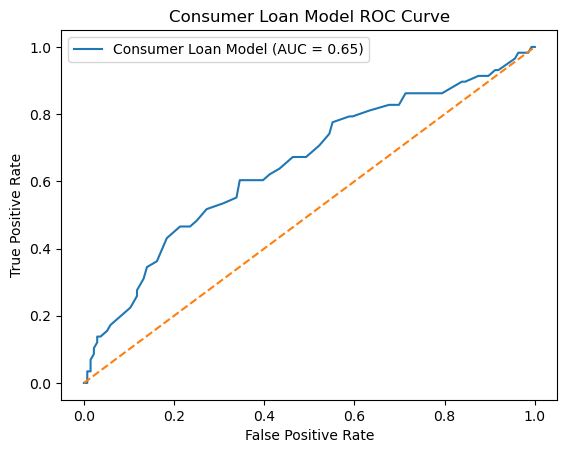

Credit Card Model - Precision: 0.6500, Recall: 0.2708, F1 Score: 0.3824, AUC-ROC: 0.6600


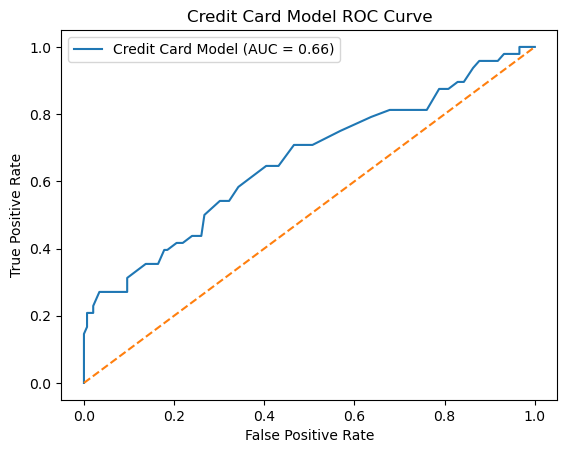

Mutual Fund Model - Precision: 0.4000, Recall: 0.0513, F1 Score: 0.0909, AUC-ROC: 0.5261


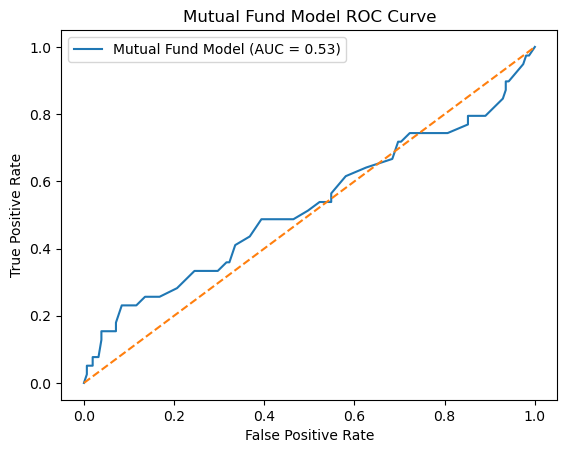

In [26]:
def evaluate_model(y_test, y_pred, model_name):
    y_pred_class = (y_pred > 0.5).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_class, average='binary')
    auc_roc = roc_auc_score(y_test, y_pred)
    print(f"{model_name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")
    
    # Plot AUC-ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

# Evaluate Models
evaluate_model(y_test_loan, y_pred_loan, "Consumer Loan Model")
evaluate_model(y_test_card, y_pred_card, "Credit Card Model")
evaluate_model(y_test_fund, y_pred_fund, "Mutual Fund Model")

## K-Fold Cross-Validation

In [27]:
def perform_cross_validation(model, X, y, model_name):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    print(f"{model_name} - Mean AUC-ROC: {scores.mean():.4f}, Std: {scores.std():.4f}")

perform_cross_validation(model_loan, X_train_loan_selected, y_train_loan, "Consumer Loan Model")
perform_cross_validation(model_card, X_train_card_selected, y_train_card, "Credit Card Model")
perform_cross_validation(model_fund, X_train_fund_selected, y_train_fund, "Mutual Fund Model")

Consumer Loan Model - Mean AUC-ROC: 0.6465, Std: 0.0418
Credit Card Model - Mean AUC-ROC: 0.5588, Std: 0.0702
Mutual Fund Model - Mean AUC-ROC: 0.5864, Std: 0.0180


## Apply models to predict propensity scores for 40% unlabelled test data

In [28]:
X_test_df = test_df.drop(columns=['Client', 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL',
                                 'Missing_All','Missing_Any'])

X_test_selected_loan = rfe_loan.transform(X_test_df)
X_test_selected_card = rfe_card.transform(X_test_df)
X_test_selected_fund = rfe_fund.transform(X_test_df)

propensity_loan = model_loan.predict_proba(X_test_selected_loan)[:, 1]
propensity_card = model_card.predict_proba(X_test_selected_card)[:, 1]
propensity_fund = model_fund.predict_proba(X_test_selected_fund)[:, 1]

## Generate seperate list for clients for individual products

In [29]:
test_df['propensity_loan'] = propensity_loan
test_df['propensity_card'] = propensity_card
test_df['propensity_fund'] = propensity_fund

In [30]:
# Generate separate lists for each product
top_loan_clients = test_df.nlargest(100, 'propensity_loan')[['Client', 'propensity_loan']]
top_card_clients = test_df.nlargest(100, 'propensity_card')[['Client', 'propensity_card']]
top_fund_clients = test_df.nlargest(100, 'propensity_fund')[['Client', 'propensity_fund']]

## Assign the best offer per client for 15%

In [31]:
test_df['best_offer'] = test_df[['propensity_loan', 'propensity_card', 'propensity_fund']].idxmax(axis=1)
test_df['best_offer'] = test_df['best_offer'].replace({
    'propensity_loan': "Consumer Loan",
    'propensity_card': "Credit Card",
    'propensity_fund': "Mutual Fund"})

In [32]:
top_clients = test_df.nlargest(int(len(test_df) * 0.15), ['propensity_loan', 'propensity_card', 'propensity_fund'])

## Save separate lists for reporting

In [33]:
top_loan_clients.to_csv("/Users/danish/Downloads/top_loan_clients.csv", index=False)
top_card_clients.to_csv("/Users/danish/Downloads/top_card_clients.csv", index=False)
top_fund_clients.to_csv("/Users/danish/Downloads/top_fund_clients.csv", index=False)
top_clients[['Client', 'best_offer']].to_csv("/Users/danish/Downloads/target_clients.csv", index=False)

## Estimate Expected Revenue

In [34]:
avg_revenue_loan = train_df['Revenue_CL'].mean()
avg_revenue_card = train_df['Revenue_CC'].mean()
avg_revenue_fund = train_df['Revenue_MF'].mean()

expected_revenue_loan = (top_clients['best_offer'] == 'Consumer Loan').sum() * avg_revenue_loan
expected_revenue_card = (top_clients['best_offer'] == 'Credit Card').sum() * avg_revenue_card
expected_revenue_fund = (top_clients['best_offer'] == 'Mutual Fund').sum() * avg_revenue_fund

total_expected_revenue = expected_revenue_loan + expected_revenue_card + expected_revenue_fund

In [35]:
# Debugging Checks
print("Offer Distribution:")
print(top_clients['best_offer'].value_counts())
print("Revenue Per Offer:")
print(f"Consumer Loan: ${expected_revenue_loan:.2f}")
print(f"Credit Card: ${expected_revenue_card:.2f}")
print(f"Mutual Fund: ${expected_revenue_fund:.2f}")
print(f"Total Expected Revenue: ${total_expected_revenue:.2f}")

Offer Distribution:
best_offer
Credit Card      84
Consumer Loan    12
Name: count, dtype: int64
Revenue Per Offer:
Consumer Loan: $43.25
Credit Card: $227.88
Mutual Fund: $0.00
Total Expected Revenue: $271.13


## Output Results

In [36]:
print("Top 15% Clients for Targeting:")
print(top_clients[['Client','propensity_loan', 'propensity_card', 'propensity_fund', 'best_offer']].head(100))

Top 15% Clients for Targeting:
      Client  propensity_loan  propensity_card  propensity_fund     best_offer
706      769             0.63             0.53             0.27  Consumer Loan
1506     223             0.62             0.60             0.20  Consumer Loan
762     1047             0.62             0.53             0.27  Consumer Loan
595     1360             0.61             0.57             0.25  Consumer Loan
1002     708             0.60             0.61             0.17    Credit Card
...      ...              ...              ...              ...            ...
941      312             0.53             0.58             0.39    Credit Card
1039    1136             0.53             0.58             0.39    Credit Card
1188    1211             0.53             0.58             0.39    Credit Card
1264     401             0.53             0.58             0.39    Credit Card
183       70             0.53             0.58             0.36    Credit Card

[96 rows x 5 columns

## Visuals for executive summary

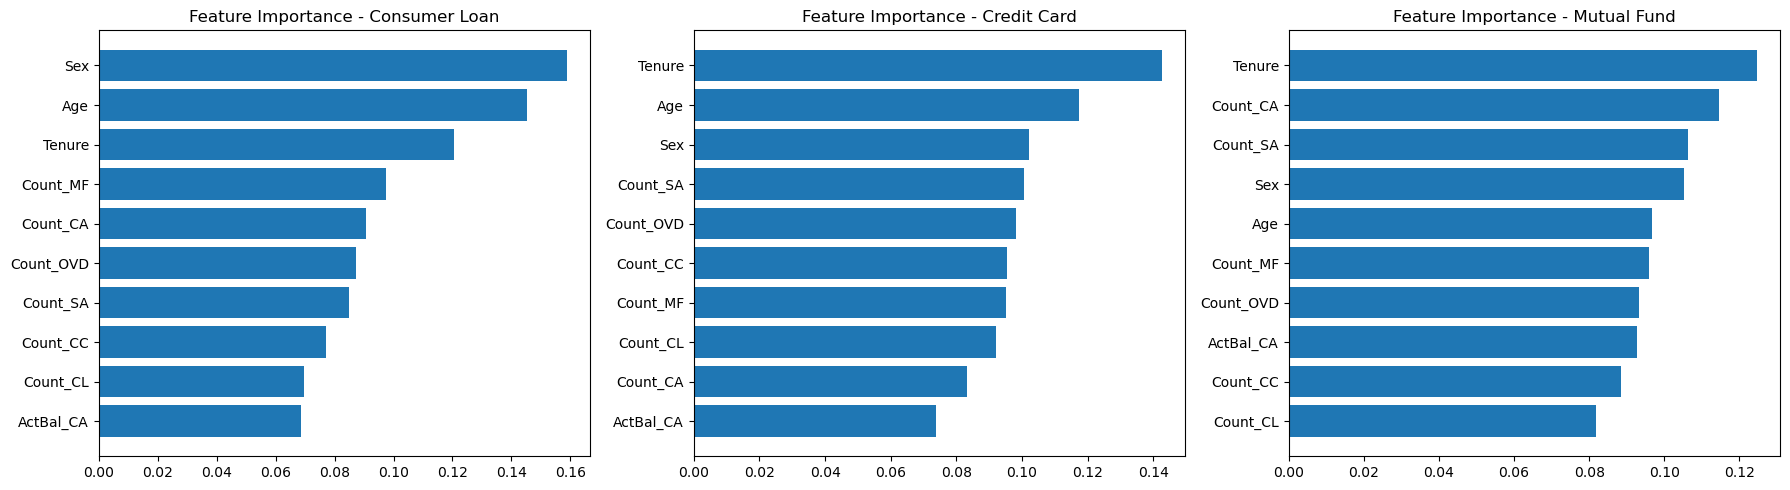

In [37]:
# Extract feature importance from the trained Random Forest model
feature_importance_loan = model_loan.feature_importances_
feature_importance_card = model_card.feature_importances_
feature_importance_fund = model_fund.feature_importances_

# Get feature names
feature_names = X.columns

# Plot feature importance for each product
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, importance, title in zip(axes, 
                                  [feature_importance_loan, feature_importance_card, feature_importance_fund], 
                                  ["Consumer Loan", "Credit Card", "Mutual Fund"]):
    sorted_idx = np.argsort(importance)[-10:]  # Select top 10 features
    ax.barh(range(10), importance[sorted_idx], align='center')
    ax.set_yticks(range(10))
    ax.set_yticklabels(np.array(feature_names)[sorted_idx])
    ax.set_title(f"Feature Importance - {title}")

plt.tight_layout()
plt.show()